# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [1]:
n_samples = 10000

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [5]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
        # Tecnología y Comunicación
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'AVGO', 'CRM', 'ADBE', 'NFLX',
        # Finanzas
        'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'AXP', 'WFC',
        # Salud
        'JNJ', 'UNH', 'LLY', 'PFE', 'ABBV', 'MRK', 'TMO', 'AMGN',
        # Consumo y Retail
        'WMT', 'COST', 'PG', 'KO', 'PEP', 'NKE', 'MCD', 'SBUX',
        # Energía e Industria
        'XOM', 'CVX', 'CAT', 'GE', 'HON', 'MMM', 'UPS', 'BA',
        # Otros (Inmobiliario, Materiales, Utilities)
        'AMT', 'PLD', 'LIN', 'APD', 'NEE', 'DUK', 'INTC', 'DIS'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Adj Close']

In [4]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


[*********************100%***********************]  50 of 50 completed


KeyError: 'Adj Close'

Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).

{'asset34', 'asset16', 'asset1', 'asset22', 'asset14', 'asset18', 'asset41', 'asset2', 'asset42'}
[33, 15, 0, 21, 13, 17, 40, 1, 41]


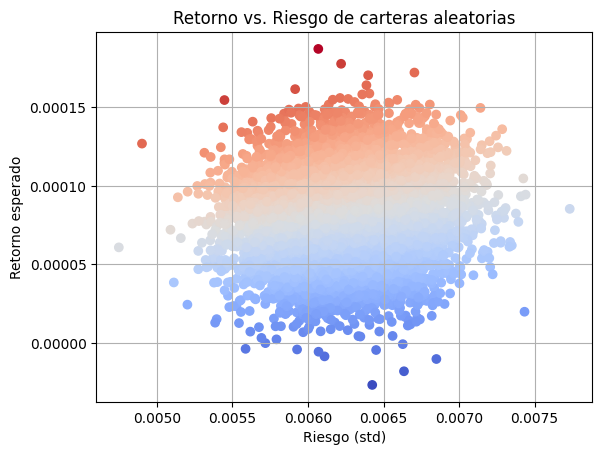

In [4]:
sharpe = returns.mean() / returns.std()

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

drop = set()
for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)

drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [9]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

min_daily_return = 0.0004 # 10% anual

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.1, # No invertimos mas de un 25% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights @ returns_means >= min_daily_return, # Minimo un 10% anual
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
for r_target in np.linspace(returns_means.min(), returns_means.max(), 100):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        row = np.concatenate([[portfolio_returns.value], [np.sqrt(portfolio_variance.value)], best_weights.value])
        results.append(row)

        print("Pesos óptimos:", best_weights.value)
        print("Retorno esperado del portfolio:", portfolio_returns.value)
        print("Volatilidad del portfolio:", np.sqrt(portfolio_variance.value))

columns = ["return", "volatility"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results.sort_values(by="return", ascending=False)
portfolio_results

Pesos óptimos: [-4.29889166e-09  1.60697801e-09 -4.18842875e-07  7.51136075e-02
  7.56154636e-02  1.00001867e-01 -6.21771763e-06  1.00001649e-01
  6.63601308e-09 -2.98848310e-06 -3.14049206e-06 -6.88501366e-07
  1.00001414e-01 -1.34538687e-09 -1.30202041e-06 -8.14962688e-11
 -8.11261622e-06  4.01808417e-10  5.73881955e-07  3.45517866e-02
 -6.34708625e-06 -8.51784112e-10  1.00002165e-01 -2.36530755e-06
 -7.00441399e-06 -1.34230008e-06 -1.97789297e-06  8.92302362e-03
 -6.94985700e-07 -7.85911026e-06 -2.15538532e-06 -3.09311911e-06
 -1.20987534e-06  4.38604226e-10  1.00000693e-01  1.00002546e-01
 -1.48655431e-09 -1.04602308e-06 -1.62183021e-07  8.49817416e-08
 -2.10777778e-09  1.01093965e-09 -2.96500264e-06  5.86561244e-03
 -3.53184435e-06  1.00000223e-01 -3.97374656e-06 -3.13799056e-06
 -6.16388018e-06 -2.34978906e-06  9.99995404e-02]
Retorno esperado del portfolio: 0.0003999960230393236
Volatilidad del portfolio: 0.005674197484062234
Pesos óptimos: [-4.29889166e-09  1.60697801e-09 -4.18

,return,volatility,asset0,asset1,asset2,asset3,asset4,asset5,asset6,asset7,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
0,0.000400,0.005674,-4.298892e-09,1.606978e-09,-4.188429e-07,0.075114,7.561546e-02,0.100002,-0.000006,0.100002,...,1.010940e-09,-0.000003,0.005866,-0.000004,0.100000,-0.000004,-0.000003,-0.000006,-0.000002,0.100000
1,0.000400,0.005674,-4.298892e-09,1.606978e-09,-4.188429e-07,0.075114,7.561546e-02,0.100002,-0.000006,0.100002,...,1.010940e-09,-0.000003,0.005866,-0.000004,0.100000,-0.000004,-0.000003,-0.000006,-0.000002,0.100000
2,0.000400,0.005674,-4.298892e-09,1.606978e-09,-4.188429e-07,0.075114,7.561546e-02,0.100002,-0.000006,0.100002,...,1.010940e-09,-0.000003,0.005866,-0.000004,0.100000,-0.000004,-0.000003,-0.000006,-0.000002,0.100000
3,0.000400,0.005674,-4.298892e-09,1.606978e-09,-4.188429e-07,0.075114,7.561546e-02,0.100002,-0.000006,0.100002,...,1.010940e-09,-0.000003,0.005866,-0.000004,0.100000,-0.000004,-0.000003,-0.000006,-0.000002,0.100000
4,0.000400,0.005674,-4.298892e-09,1.606978e-09,-4.188429e-07,0.075114,7.561546e-02,0.100002,-0.000006,0.100002,...,1.010940e-09,-0.000003,0.005866,-0.000004,0.100000,-0.000004,-0.000003,-0.000006,-0.000002,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.000401,0.005686,-7.410781e-09,2.838941e-09,-7.032284e-07,0.075010,7.492148e-02,0.100003,-0.000011,0.100003,...,1.789727e-09,-0.000005,0.006168,-0.000006,0.100000,-0.000007,-0.000005,-0.000011,-0.000004,0.099999
79,0.000415,0.005862,-7.105746e-09,3.171653e-09,-5.209162e-07,0.073531,6.515559e-02,0.100003,-0.000010,0.100003,...,1.963388e-09,-0.000005,0.010365,-0.000007,0.100001,-0.000006,-0.000005,-0.000012,-0.000005,0.099999
80,0.000430,0.006060,-6.097466e-09,2.084287e-09,-1.088965e-06,0.083303,2.191183e-02,0.100001,-0.000009,0.100001,...,-2.453940e-10,-0.000006,0.018566,-0.000007,0.099999,-0.000004,-0.000005,-0.000011,-0.000006,0.099996
81,0.000444,0.006352,1.668493e-10,-2.066790e-09,2.555480e-07,0.099998,1.716827e-06,0.099999,0.000003,0.100000,...,9.889242e-10,0.000003,0.036607,0.000006,0.052116,-0.000001,0.000002,0.000008,0.000004,0.086933


In [11]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [12]:
rounded_weights = round_weights(portfolio_results.iloc[0, 2:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)

['0', '0', '0', '0.075', '0.075', '0.101', '0', '0.101', '0', '0', '0', '0', '0.101', '0', '0', '0', '0', '0', '0', '0.034', '0', '0', '0.101', '0', '0', '0', '0', '0.008', '0', '0', '0', '0', '0', '0', '0.1', '0.1', '0', '0', '0', '0', '0', '0', '0', '0.005', '0', '0.1', '0', '0', '0', '0', '0.099']


In [14]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Sortino:", downside_deviation)

Sortino: 0.00616325125407534
